#### Source: [Github repo](https://github.com/nachiket273/One_Cycle_Policy) by Nachiket272

# CIFAR with cyclic LR and One Cycle

This notebook will use CIFAR-10 dataset and resnet56 model and try to recreate results from following 2 papers:<br>
1) Learning Rate Finder (Cyclic learning rates) (https://arxiv.org/abs/1506.01186)<br>
2) One Cycle Policy ( Using Cyclic momentum with cyclic learning rates) (https://arxiv.org/abs/1803.09820)<br><br>

We'll use standard transformations as random horizontal flips and random crops after adding padding. We'll use reflection padding. If possible we'll also apply cutout and other transforms just to see how they affect the final accuracy.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import math
import tqdm as tqdm
import CLR as CLR
import OneCycle as OneCycle

In [3]:
gpu = True if torch.cuda.is_available() else False
gpu

True

In [4]:
mean = [0.491, 0.482, 0.447]
std = [0.247, 0.243, 0.262] #mean and standard deviation for CIFAR dataset

In [5]:
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])

## Load data into dataloaders

In [6]:
trainset = CIFAR10('./data', train=True, download=True, transform=transform)
testset = CIFAR10('./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
bs=512
epoch=95
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=4)

## Plotting Function

In [9]:
# Plot few of the images
# This can be used to print predictions too
def plot_img(preds=None, is_pred=False):        
    fig = plt.figure(figsize=(8,8));
    columns = 4;
    rows = 5;

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred:
            img_xy = np.random.randint(len(testset));
            img = testset[img_xy][0].numpy()
            #img = img * std + mean
        else:
            img_xy = np.random.randint(len(trainset));
            img = trainset[img_xy][0].numpy()
            #img = img * std + mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img , (1,2,0)), interpolation='nearest')
    plt.show()

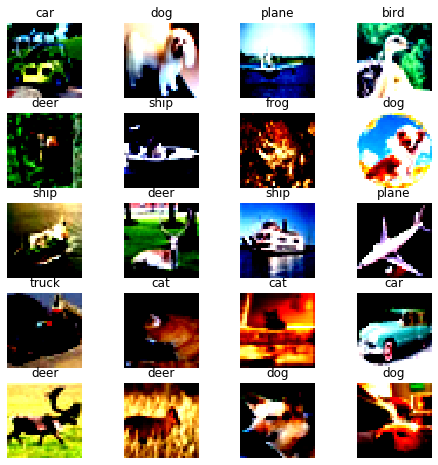

In [10]:
plot_img()

## Model
We use resnet56 here.<br>

In [11]:
class BasicBlock(nn.Module):
    def __init__(self, cnin, cnout, stride=1, downsample=None):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(cnout)
        self.conv1 = nn.Conv2d(cnin, cnout, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(cnout)
        self.conv2 = nn.Conv2d(cnout, cnout, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.downsample = downsample
        
        if stride != 1 or cnin != cnout:
            self.shortcut = nn.Sequential(
                            nn.Conv2d(cnin, cnout, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(cnout)
                            )
            
    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)
        
        out = self.conv2(out)
        out = self.bn2(out)

        out += shortcut
        return F.relu(out)

In [12]:
class Resnet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_layer_group(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_layer_group(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_layer_group(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        
    def make_layer_group(self, chin, chout, num_blocks, stride=1):
        layers = [BasicBlock(chin, chout, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(chout, chout, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [13]:
model = Resnet([9,9,9])

In [14]:
model = model.cuda() if gpu else model.cpu()

In [15]:
model

Resnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

## Some helper Functions
Function to calculate accuracy. And a Class to track accuracy and losses while training.

In [16]:
def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = target.size(0)
    total += batch_size
    
    _, pred = torch.max(output, 1)
    if is_test:
        preds.extend(pred)
    correct += (pred == target).sum()
    return 100 * correct / total

In [17]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

In [18]:
train_stats = AvgStats()
test_stats = AvgStats()

## Define Loss Function and Optimizer
<br>We use CrossEntropyLoss as loss function<br>
We use SGD with learning rate of 0.01 and momentum value of 0.9 <br>
( We'll later how to find optimized learning rate)<br>

In [19]:
# define optimizer and loss function
criterion = nn.CrossEntropyLoss()

In [20]:
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr= 0.005, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-4)

## Cyclic Learning Rates
We'll use method described in paper : https://arxiv.org/abs/1506.01186 to find out optimum learning rate.<br>
We'll increase the learning rate from lower value per iteration for some iterations till loss starts exploding.<br>
We'll plot loss vs learning rate plot.<br>
We'll then select learning rate that is one power higher than the one where loss is minimum <br>
This value can be used as maximum value in Cyclic Learning Rate policy and minimum learning rate <br>
can be set to 1/3, 1/4th of max value.

In [21]:
clr = CLR.CLR(optimizer, len(train_loader))

In [22]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [23]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

## Checkpoint

In [24]:
def save_checkpoint(model, is_best, filename='data/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [25]:
# from fastai library
def load_checkpoint(model, filename = 'data/checkpoint.pth.tar'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

In [26]:
filename = 'data/clr.pth.tar'
save_checkpoint(model, True, filename)

In [27]:
t = tqdm.tqdm(train_loader, leave=False, total=len(train_loader))
running_loss = 0.
avg_beta = 0.98
model.train()
for i, (input, target) in enumerate(t):
    if gpu :
        input, target = input.cuda(), target.cuda() 
    else :
        input, target = input.cpu(), target.cpu()
    var_ip, var_tg = Variable(input), Variable(target)
    output = model(var_ip)
    loss = criterion(output, var_tg)
    #print(loss.data)
    running_loss = avg_beta * running_loss + (1-avg_beta) *loss.data
    smoothed_loss = running_loss / (1 - avg_beta**(i+1))
    t.set_postfix(loss=smoothed_loss)
    
    lr = clr.calc_lr(smoothed_loss)
    if lr == -1 :
        break
    update_lr(optimizer, lr)   
    
    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
   # print('Iteration: [{0}/{1}]  '
        # 'Loss: {2}  '.format(i, len(train_loader), smoothed_loss))

 93%|█████████▎| 91/98 [00:19<00:01,  4.84it/s, loss=tensor(42.1188, device='cuda:0')]

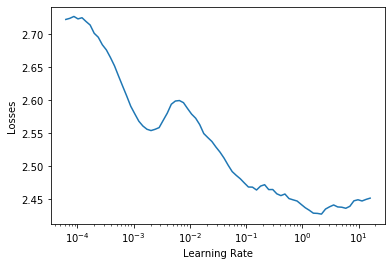

In [28]:
clr.plot()

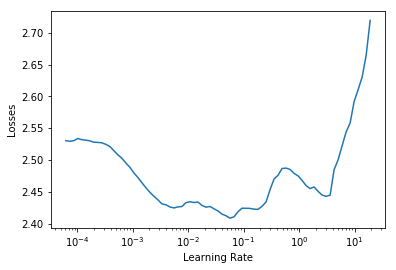

In [27]:
# OLD PLOT
clr.plot()

## One Cycle Policy

In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during whole run with 2 steps of equal length. During first step, increase the learning rate from lower learning rate to higher learning rate. And in second step, decrease it from higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one addition to this. - During last few hundred/thousand iterations of cycle reduce the learning rate to 1/100th or 1/1000th of the lower learning rate.

Also, Author suggests that reducing momentum when learning rate is increasing. So, we make one cycle of momentum also with learning rate - Decrease momentum when learning rate is increasing and increase momentum when learning rate is decreasing.

In [29]:
onecycle = OneCycle.OneCycle(int(len(trainset) * epoch /bs), 0.8, prcnt=(epoch - 82) * 100/epoch, momentum_vals=(0.95, 0.8))

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.95, weight_decay=1e-4)

In [31]:
#model = Resnet([9,9,9])
#model = model.cuda() if gpu else model.cpu()
load_checkpoint(model, filename)

## Train

In [32]:
total = 0
correct = 0

In [33]:
train_loss = 0
test_loss = 0
best_acc = 0
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

In [34]:
def train(epoch=0, use_cycle = False, model=model):
    model.train()
    global best_acc
    global trn_accs, trn_losses
    is_improving = True
    counter = 0
    running_loss = 0.
    avg_beta = 0.98
        
    for i, (input, target) in enumerate(train_loader):
        bt_start = time.time()
        if gpu :
            input, target = input.cuda(), target.cuda() 
        else :
            input, target = input.cpu(), target.cpu()
        var_ip, var_tg = Variable(input), Variable(target)
                
        if use_cycle:    
            lr, mom = onecycle.calc()
            update_lr(optimizer, lr)
            update_mom(optimizer, mom)
            
        output = model(var_ip)
        loss = criterion(output, var_tg)
            
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.data
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        
        trn_losses.append(smoothed_loss)
            
        # measure accuracy and record loss
        prec = accuracy(output.data, target)
        trn_accs.append(prec)

        train_stats.append(smoothed_loss, prec, time.time()-bt_start)
        if prec > best_acc :
            best_acc = prec
            save_checkpoint(model, True)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [35]:
preds =[]

In [36]:
def test(model=model):
    model.eval()
    global val_accs, val_losses
    running_loss = 0.
    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):
            bt_start = time.time()
            if gpu :
                input, target = input.cuda(), target.cuda() 
            else :
                input, target = input.cpu(), target.cpu()
            var_ip, var_tg = Variable(input, volatile=True), Variable(target, volatile=True)
            output = model(var_ip)
            loss = criterion(output, var_tg)

            running_loss = avg_beta * running_loss + (1-avg_beta) *loss.data
            smoothed_loss = running_loss / (1 - avg_beta**(i+1))

            # measure accuracy and record loss
            prec = accuracy(output.data, target, is_test=True)
            test_stats.append(loss.data, prec, time.time()-bt_start)

            val_losses.append(smoothed_loss)
            val_accs.append(prec)

In [37]:
def fit(use_onecycle=False, model=model):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    for j in range(epoch):
        train(j, use_onecycle, model)
        test(model)
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_losses[-1], val_losses[-1], trn_accs[-1], val_accs[-1]))

In [38]:
fit(True)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc


/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


1	1.93312263	1.79921210	23.00000000	24.00000000
2	1.58855450	1.62366629	30.00000000	31.00000000
3	1.37512708	1.48906064	36.00000000	36.00000000
4	1.17715657	1.28409576	41.00000000	41.00000000
5	1.00055563	1.11560619	45.00000000	46.00000000
6	0.85760534	1.01603556	49.00000000	49.00000000
7	0.74779671	0.99080217	52.00000000	52.00000000
8	0.65589201	0.83623004	55.00000000	55.00000000
9	0.56345481	0.80935431	58.00000000	58.00000000
10	0.51764667	0.65858775	60.00000000	60.00000000
11	0.45832580	0.62181300	62.00000000	62.00000000
12	0.40846667	0.65404350	64.00000000	64.00000000
13	0.37946656	0.79410261	66.00000000	66.00000000
14	0.33998594	0.58346939	67.00000000	67.00000000
15	0.30760783	0.66799968	68.00000000	69.00000000
16	0.28792116	0.96554589	70.00000000	70.00000000
17	0.25432631	1.08787727	71.00000000	71.00000000
18	0.25144514	0.81979138	72.00000000	72.00000000
19	0.22073931	0.79309237	73.00000000	73.00000000
20	0.19258334	0.69412172	74.00000000	74.00000000
21	0.18864022	0.68364817	74.0

In [37]:
# OLD
fit(True)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	1.69870388	2.52984036	31.38600000	30.28833333
2	1.29663418	1.31515600	39.32818182	40.46666667
3	1.03141871	1.17180820	46.82117647	47.50555556
4	0.87374358	1.03223278	52.08086957	52.65250000
5	0.74264513	1.00683639	56.22000000	56.56600000
6	0.64582372	0.79743319	59.52314286	59.88861111
7	0.57520450	0.86881687	62.36878049	62.58166667
8	0.51948472	0.78290827	64.63574468	64.83250000
9	0.47376741	0.67175730	66.60962264	66.81111111
10	0.42941259	0.91662614	68.39661017	68.46116667
11	0.39895808	0.73683272	69.85030769	69.94227273
12	0.36830060	0.72980209	71.18352113	71.25750000
13	0.33974871	0.72769972	72.37974026	72.43910256
14	0.31189484	0.64295130	73.47614458	73.55380952
15	0.28800290	0.75451627	74.48359551	74.51533333
16	0.27850878	0.81896415	75.37978947	75.37552083
17	0.25692977	0.90127825	76.15910891	76.15450980
18	0.23586536	0.86026396	76.89962617	76.89509259
19	0.23517090	0.81518870	77.57672566	77.57342105
20	0.21541902	0.91534104	78.22058824	

In [39]:
# for train
ep_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_losses.append(train_stats.losses[i])
        
# for val
ep_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lossesv.append(test_stats.losses[i])

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


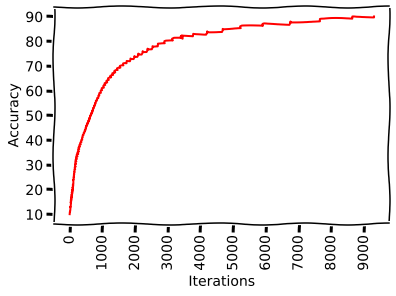

In [40]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 100, step=10))
plt.plot(train_stats.precs, 'r')
plt.xticks(np.arange(0, len(train_stats.precs), step=1000), rotation=90)
plt.savefig('onecycle_acc.jpg')

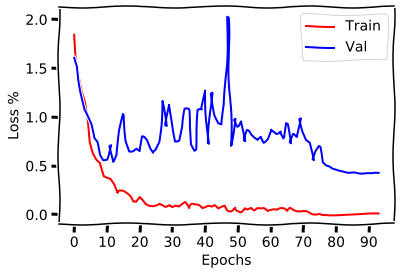

In [41]:
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Loss %")
plt.xticks(np.arange(0, 100, step=10))
plt.plot(ep_losses, 'r', label='Train')
plt.plot(ep_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('onecycle_loss.jpg')

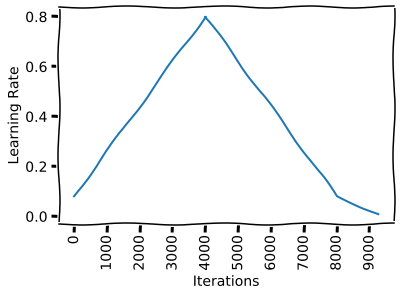

In [42]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=1000), rotation=90)
plt.plot(onecycle.lrs[:9276])
plt.savefig('onecycle_lr.jpg')

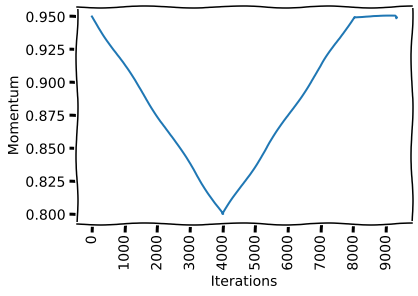

In [43]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Momentum")
plt.xticks(np.arange(0, len(onecycle.moms), step=1000), rotation=90)
plt.plot(onecycle.moms)
plt.savefig('onecycle_mom.jpg')

## Use Constant Momentum

In [48]:
%reset?

In [51]:
%reset_selective -f model

In [49]:
reset()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  (), please run `%reset?` for details


In [38]:
onecycle = OneCycle.OneCycle(int(len(trainset) * epoch /bs), 0.8, prcnt=13.68, momentum_vals=(0.9, 0.9))
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9, weight_decay=1e-4)
model2 = Resnet([9,9,9])
model2 = model.cuda() if gpu else model.cpu()

In [39]:
fit(model=model2, use_onecycle=True)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc


/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


1	1.84963048	1.75776887	26.00000000	28.00000000
2	1.38999069	1.31630552	36.00000000	37.00000000
3	1.10274184	1.10122597	44.00000000	45.00000000
4	0.89981544	1.13829374	49.00000000	50.00000000
5	0.76483625	1.37184584	54.00000000	54.00000000
6	0.66308516	0.96624392	57.00000000	57.00000000
7	0.59301543	0.88463539	60.00000000	60.00000000
8	0.52538341	0.87986827	62.00000000	63.00000000
9	0.48649481	0.77415633	65.00000000	65.00000000
10	0.43917406	0.67574489	66.00000000	67.00000000
11	0.41326749	0.74986082	68.00000000	68.00000000
12	0.37790856	0.64396799	69.00000000	70.00000000
13	0.34846073	0.94708890	71.00000000	71.00000000
14	0.33280197	0.80001444	72.00000000	72.00000000
15	0.30253977	0.77926958	73.00000000	73.00000000
16	0.30414215	1.20754266	74.00000000	74.00000000
17	0.28598610	0.68989909	74.00000000	75.00000000
18	0.25910553	0.72344136	75.00000000	75.00000000
19	0.24640901	0.77547354	76.00000000	76.00000000
20	0.25437573	0.92550719	77.00000000	77.00000000
21	0.23956144	0.73656553	77.0

In [36]:
# OLD
fit(model=model2, use_onecycle=True)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	1.18704142	1.62517763	54.36200000	53.41333333
2	0.92906480	1.45357801	59.14454545	58.60166667
3	0.76242406	1.17522450	62.75823529	62.69000000
4	0.64356394	0.84375595	65.85434783	66.10166667
5	0.58843564	1.10162181	68.40275862	68.33000000
6	0.51956626	0.87235644	70.29171429	70.30944444
7	0.48357608	0.82074679	71.92292683	71.95380952
8	0.44034476	0.92385528	73.36361702	73.31020833
9	0.41020749	0.81772078	74.51566038	74.53314815
10	0.37241128	0.88967052	75.61508475	75.56866667
11	0.36318950	0.63985543	76.50876923	76.55378788
12	0.32960029	0.92101016	77.41309859	77.36194444
13	0.30769181	0.66157010	78.14701299	78.16102564
14	0.30042714	0.81402624	78.86843373	78.83464286
15	0.28190288	0.85117354	79.50112360	79.47666667
16	0.27741743	0.93460099	80.06789474	80.02010417
17	0.25714453	0.71259525	80.56544554	80.53901961
18	0.24384335	1.37460131	81.06719626	80.94435185
19	0.24622344	0.97629781	81.43088496	81.37385965
20	0.22400028	1.51300422	81.83890756	

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


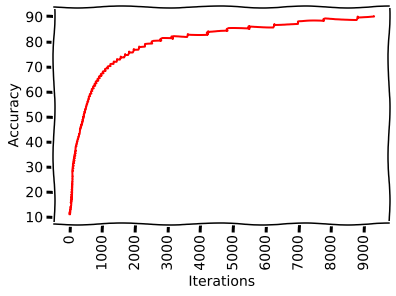

In [40]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 100, step=10))
plt.plot(train_stats.precs, 'r')
plt.xticks(np.arange(0, len(train_stats.precs), step=1000), rotation=90)
plt.savefig('onecycle_acc_fixmom.jpg')

In [41]:
# train
ep_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_losses.append(train_stats.losses[i])

# val
ep_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lossesv.append(test_stats.losses[i])

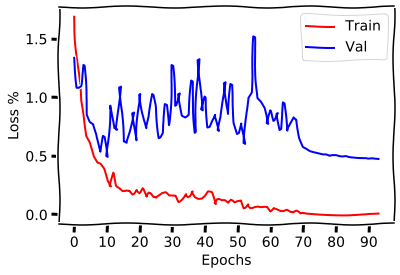

In [42]:
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Loss %")
plt.xticks(np.arange(0, 100, step=10))
plt.plot(ep_losses, 'r', label='Train')
plt.plot(ep_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('onecycle_loss_fixmom.jpg')

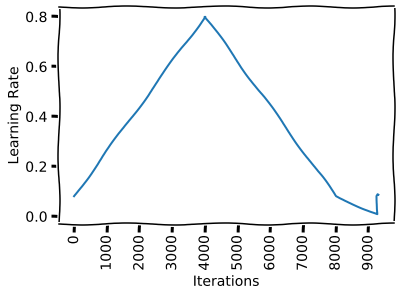

In [43]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=1000), rotation=90)
plt.plot(onecycle.lrs)
plt.savefig('onecycle_lr_fixmom.jpg')

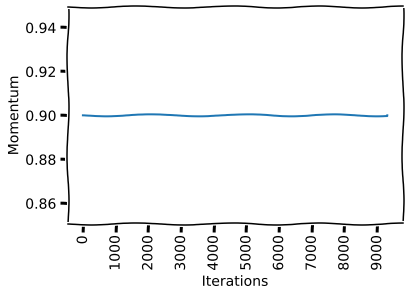

In [44]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Momentum")
plt.xticks(np.arange(0, len(onecycle.moms), step=1000), rotation=90)
plt.plot(onecycle.moms)
plt.savefig('onecycle_mom_fixmom.jpg')

### Try with larger learning rates and smaller cycle.

We will now try with CLR - 0.15 to 3 and we'll do 50 epoch with step size of 22.5 epochs

In [45]:
epoch = 50

In [46]:
def reset():
    global train_loss, test_loss, best_acc, trn_losses, trn_accs
    global val_losses, val_accs, preds, total, correct
    global train_stats, test_stats, avg_beta
    train_loss = 0
    test_loss = 0
    best_acc = 0
    trn_losses = []
    trn_accs = []
    val_losses = []
    val_accs = []
    preds =[]
    total = 0
    correct = 0
    train_stats = AvgStats()
    test_stats = AvgStats()
    avg_beta = 0.98

In [47]:
reset()

In [48]:
onecycle = OneCycle.OneCycle(int(len(trainset) * epoch /bs), 3, prcnt=10, momentum_vals=(0.95, 0.8), div=20)
optimizer = torch.optim.SGD(model.parameters(), lr=0.15, momentum=0.95, weight_decay=1e-4)
model1 = Resnet([9,9,9])
model1 = model.cuda() if gpu else model.cpu()

In [42]:
fit(True, model=model1)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	1.33188591	1.57090080	49.01400000	48.58333333
2	1.08812643	1.27514984	53.51090909	53.66833333
3	0.88372891	0.91585043	57.80823529	58.38000000
4	0.73430662	1.06255306	61.71913043	61.87291667
5	0.66323805	0.89220205	64.44379310	64.62700000
6	0.60826655	0.88531992	66.70085714	66.79611111
7	0.56162958	1.09905039	68.44609756	68.33476190
8	0.51729403	1.15495376	69.82723404	69.76083333
9	0.49771347	0.72766522	71.00603774	71.09111111
10	0.47242087	0.75276129	72.20033898	72.24750000
11	0.44359334	0.79273276	73.22569231	73.24651515
12	0.43970295	1.23674476	74.08971831	73.96611111
13	0.42710754	0.80941182	74.72818182	74.72128205
14	0.40283024	0.78364055	75.42554217	75.40511905
15	0.40340401	0.96069269	76.02595506	75.99000000
16	0.37581918	1.01637286	76.58294737	76.53750000
17	0.37968900	0.96997039	77.07009901	77.02500000
18	0.38827240	0.86217105	77.48794393	77.44407407
19	0.36561315	0.62939720	77.89380531	77.90622807
20	0.35984576	0.79725987	78.32647059	

/home/nachiket.tanksale/.conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


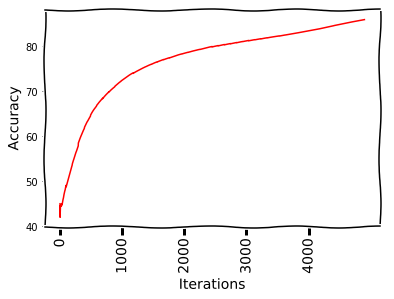

In [43]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 100, step=10))
plt.plot(train_stats.precs, 'r')
plt.xticks(np.arange(0, len(train_stats.precs), step=1000), rotation=90)
plt.savefig('onecycle_acc_50.jpg')

In [45]:
ep_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_losses.append(train_stats.losses[i])
        
ep_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lossesv.append(test_stats.losses[i])

/home/nachiket.tanksale/.conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


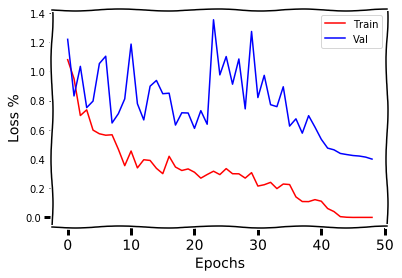

In [46]:
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Loss %")
plt.xticks(np.arange(0, 100, step=10))
plt.plot(ep_losses, 'r', label='Train')
plt.plot(ep_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('onecycle_loss_50.jpg')

/home/nachiket.tanksale/.conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


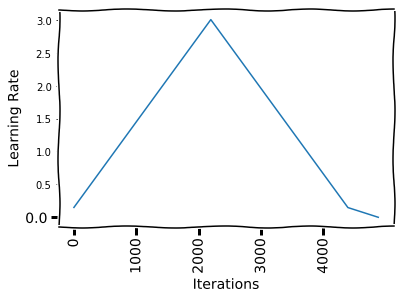

In [60]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=1000), rotation=90)
plt.plot(onecycle.lrs[:4881])
plt.savefig('onecycle_lr_50.jpg')

/home/nachiket.tanksale/.conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


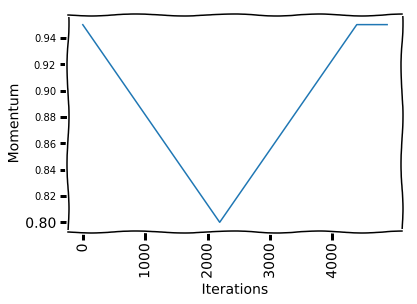

In [62]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Momentum")
plt.xticks(np.arange(0, len(onecycle.moms), step=1000), rotation=90)
plt.plot(onecycle.moms[:4881])
plt.savefig('onecycle_mom_50.jpg')

## The weight decay value matters too

Now we'll run with weight decay values of 1e-3 and 1e-5 all plot the results. We already have results for 1e-4

In [31]:
onecycle = OneCycle.OneCycle(int(len(trainset) * epoch /bs), 3, prcnt=10, momentum_vals=(0.95, 0.8), div=20)
optimizer = torch.optim.SGD(model.parameters(), lr=0.15, momentum=0.95, weight_decay=1e-3)
model1 = Resnet([9,9,9])
model1 = model.cuda() if gpu else model.cpu()

In [32]:
epoch = 50

In [34]:
fit(model=model1, use_onecycle=True)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	1.76257530	2.21288300	29.50200000	28.33500000
2	1.46145038	1.52700327	35.51181818	36.29333333
3	1.23813987	2.26970964	41.55176471	41.08277778
4	1.02192884	1.62237186	45.76217391	45.95833333
5	0.90796683	1.22582107	49.73793103	49.98766667
6	0.87288168	2.93562182	52.74914286	52.34722222
7	0.83794599	1.11469652	54.62463415	54.82238095
8	0.81696995	4.82536267	56.60148936	55.87541667
9	0.82914529	1.21443738	57.33962264	57.32870370
10	0.81681854	1.46385999	58.55084746	58.44333333
11	0.83801611	2.33263233	59.43600000	59.01136364
12	0.83270465	2.80305910	59.91676056	59.53638889
13	0.84334442	2.95940408	60.30883117	59.92500000
14	0.84463378	1.86194292	60.57048193	60.36773810
15	0.87734505	4.10087539	60.90561798	60.40388889
16	0.84393371	1.86853839	60.94947368	60.72458333
17	0.86693041	3.16634152	61.19415842	60.82323529
18	0.87339958	1.66357521	61.26364486	61.15296296
19	0.86790588	2.33807016	61.55026549	61.35149123
20	0.87328394	2.56049739	61.72411765	

In [35]:
ep_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_losses.append(train_stats.losses[i])
        
ep_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lossesv.append(test_stats.losses[i])

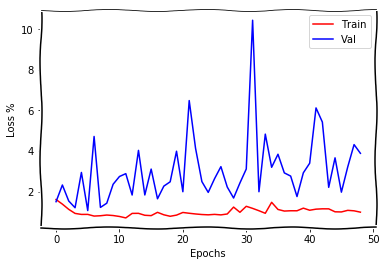

In [37]:
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Loss %")
plt.xticks(np.arange(0, 100, step=10))
plt.plot(ep_losses, 'r', label='Train')
plt.plot(ep_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('onecycle_loss_1e-3.jpg')

/home/nachiket.tanksale/.conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


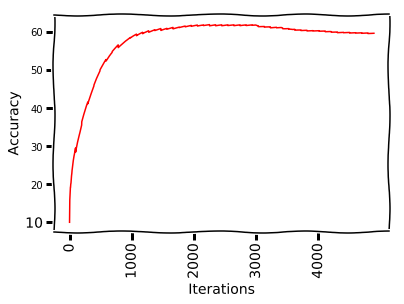

In [38]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 100, step=10))
plt.plot(train_stats.precs, 'r')
plt.xticks(np.arange(0, len(train_stats.precs), step=1000), rotation=90)
plt.savefig('onecycle_acc_1e-3.jpg')

### weight_decay = 1e-5

In [39]:
onecycle = OneCycle.OneCycle(int(len(trainset) * epoch /bs), 3, prcnt=10, momentum_vals=(0.95, 0.8), div=20)
optimizer = torch.optim.SGD(model.parameters(), lr=0.15, momentum=0.95, weight_decay=1e-5)
model3 = Resnet([9,9,9])
model3 = model.cuda() if gpu else model.cpu()

In [40]:
reset()

In [41]:
load_checkpoint(model3, filename)

In [42]:
fit(model=model3, use_onecycle=True)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	1.83373343	1.82216213	27.63000000	28.53833333
2	1.53503369	1.87814399	34.21181818	34.45833333
3	1.28730517	1.29090292	39.47705882	40.23444444
4	1.05405385	1.04854420	44.72565217	45.45833333
5	0.86069177	0.89449114	49.44379310	50.06233333
6	0.74207589	0.89881649	53.44314286	53.88166667
7	0.64851777	1.16330979	56.72463415	56.83404762
8	0.57958966	1.00685275	59.28510638	59.49812500
9	0.52986328	0.72528137	61.61867925	61.87537037
10	0.47428545	0.69776444	63.71542373	63.93700000
11	0.41995257	0.83449843	65.58000000	65.70833333
12	0.38747335	0.70962173	67.19042254	67.33652778
13	0.35644331	0.84663580	68.66987013	68.74371795
14	0.32267736	0.79579093	69.97289157	70.04559524
15	0.28994268	0.84151760	71.17000000	71.21411111
16	0.27982944	0.72096764	72.23957895	72.31250000
17	0.24494348	1.00078506	73.26920792	73.28186275
18	0.23097211	0.86578900	74.16186916	74.19018519
19	0.20395284	0.86504575	75.02734513	75.05877193
20	0.19607687	0.86194220	75.82403361	

In [45]:
ep_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_losses.append(train_stats.losses[i])
        
ep_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lossesv.append(test_stats.losses[i])

/home/nachiket.tanksale/.conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


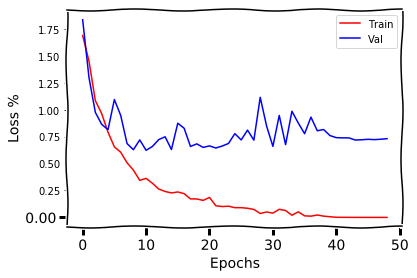

In [46]:
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Loss %")
plt.xticks(np.arange(0, 100, step=10))
plt.plot(ep_losses, 'r', label='Train')
plt.plot(ep_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('onecycle_loss_1e-5.jpg')

/home/nachiket.tanksale/.conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


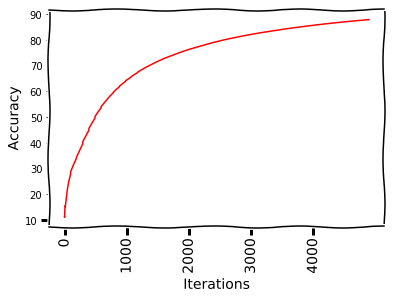

In [43]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 100, step=10))
plt.plot(train_stats.precs, 'r')
plt.xticks(np.arange(0, len(train_stats.precs), step=1000), rotation=90)
plt.savefig('onecycle_acc_1e-5.jpg')